In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import  to_categorical
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint,Callback



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Data

In [4]:
train = pd.read_csv("/content/drive/MyDrive/emnist/emnist-balanced-train.csv")
test = pd.read_csv("/content/drive/MyDrive/emnist/emnist-balanced-test.csv")


In [5]:
print(train.shape)
print(test.shape)

(112799, 785)
(18799, 785)


In [6]:
lables = ['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a','b','d','e','f','g','h','n','q','r','t']

split dataframe to arrays  

In [7]:
y_train=np.array((train.iloc[:,0]).values)
x_train=np.array((train.iloc[:,1:]).values)
y_test=np.array((test.iloc[:,0]).values)
x_test=np.array((test.iloc[:,1:]).values)

Classes of y_train

In [8]:
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


Plot the images

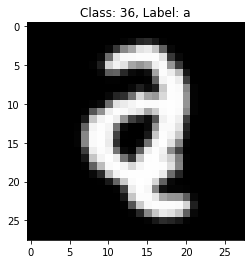

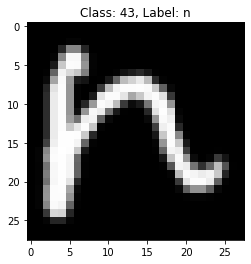

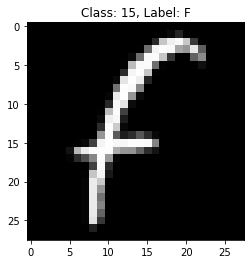

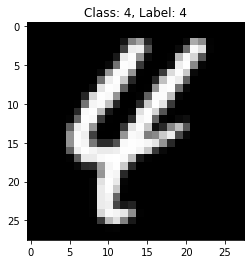

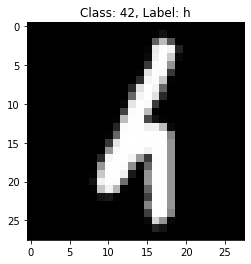

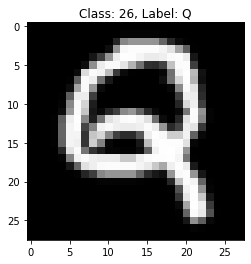

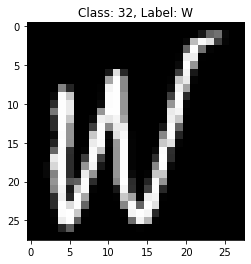

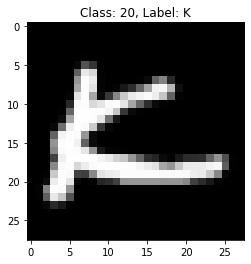

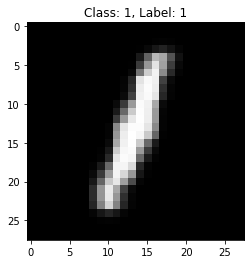

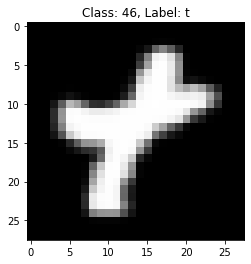

In [11]:
for i in range(10) : 
   image = train.values[i, 1:].reshape([28, 28])
   image = np.fliplr(image)
   image = np.rot90(image)
   plt.imshow(image, cmap='Greys_r')
   plt.title('Class: ' + str(train.values[i,0]) + ', Label: ' + str(lables[train.values[i,0]]))
   plt.show()

# Data Preprocessing

In [12]:
x_train = x_train.reshape(-1, 28,28, 1)
x_test = x_test.reshape(-1, 28,28, 1)

scaling the data between (0 and 1) to speed the model

In [13]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

make the target varaible categorical for classification

In [14]:
y_train=to_categorical(y_train)
y_test_t=to_categorical (y_test)


# Model the Data

In [15]:
from sklearn.model_selection import train_test_split
x_train,x_valid,train_label,valid_label = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [16]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))

model.add(Dropout(0.25))

model.add(Dense(47, activation = "softmax"))

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

# Callback

In [17]:
class MyThresholdCallback(Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

In [18]:
pa = EarlyStopping(monitor='val_accuracy', min_delta=0, verbose=0, restore_best_weights=True, patience=3,
                      mode='max')
red = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.0001)

# Data augmauntation

In [19]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=3,  
        zoom_range = 0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1)  

datagen.fit(x_train)


In [20]:
history = model.fit(datagen.flow(x_train, train_label, batch_size=64),
                              epochs =20, validation_data = (x_valid, valid_label),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 64
                              , callbacks=[red,pa])

Epoch 1/20
1409/1409 [==============================] - 74s 45ms/step - loss: 0.9516 - accuracy: 0.7071 - val_loss: 0.3798 - val_accuracy: 0.8582 - lr: 0.0010
Epoch 2/20
1409/1409 [==============================] - 50s 36ms/step - loss: 0.4974 - accuracy: 0.8291 - val_loss: 0.3526 - val_accuracy: 0.8680 - lr: 0.0010
Epoch 3/20
1409/1409 [==============================] - 48s 34ms/step - loss: 0.4416 - accuracy: 0.8451 - val_loss: 0.3374 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 4/20
1409/1409 [==============================] - 48s 34ms/step - loss: 0.4127 - accuracy: 0.8544 - val_loss: 0.3096 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 5/20
1409/1409 [==============================] - 48s 34ms/step - loss: 0.3922 - accuracy: 0.8596 - val_loss: 0.3138 - val_accuracy: 0.8799 - lr: 0.0010
Epoch 6/20
1409/1409 [==============================] - 53s 37ms/step - loss: 0.3765 - accuracy: 0.8636 - val_loss: 0.3096 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 7/20
1409/1409 [========================

plot the loss and accurcy function for training and validation set

In [21]:
def plotgraph(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
  

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

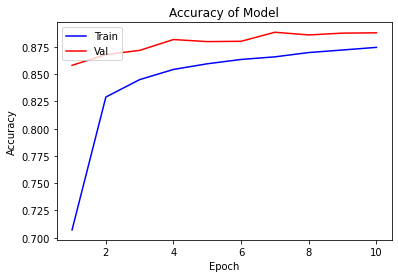

In [23]:
plotgraph(epochs, acc, val_acc)
plt.title('Accuracy of Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

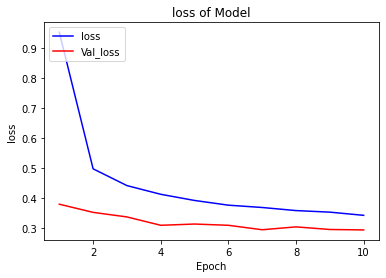

In [24]:
plotgraph(epochs, loss, val_loss)
plt.title('loss of Model')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Val_loss'], loc='upper left')
plt.show()

# Model Evaluation on the Test Set

In [25]:
score = model.evaluate(x_test, y_test_t, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
predictions = model.predict(x_test)
print("predictions shape:", predictions.shape)

Test loss: 0.31294387578964233
Test accuracy: 0.8871748447418213
predictions shape: (18799, 47)


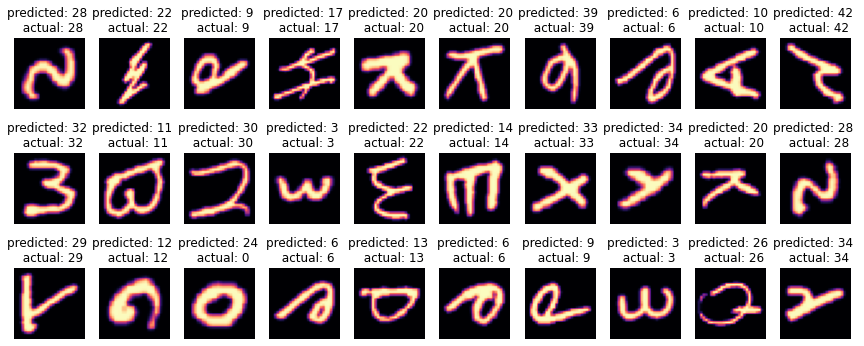

In [26]:
import random
test_samples = random.sample(range(0, len(x_test)), 30) # select 30 samples

# display results
plt.figure(figsize=(15, 6))
for i in test_samples:
    plt.subplot(3, 10, test_samples.index(i) + 1)  
    plt.imshow(x_test[i].reshape(28,28), cmap='magma')
    plt.title(f'predicted: {np.argmax(predictions[i] )} \n  actual: {y_test[i]}')
    plt.axis('off')

## Confusion Matrix

In [58]:
y_pred= predictions.argmax(axis=1)


In [57]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_pred,y_test)
print(matrix)

[[304   0   0 ...   0   0   0]
 [  0 263   0 ...   0   0   0]
 [  0   0 370 ...   0   0   0]
 ...
 [  0   0   0 ... 192   0   0]
 [  0   1   0 ...   0 379   5]
 [  0   1   0 ...   0   0 367]]


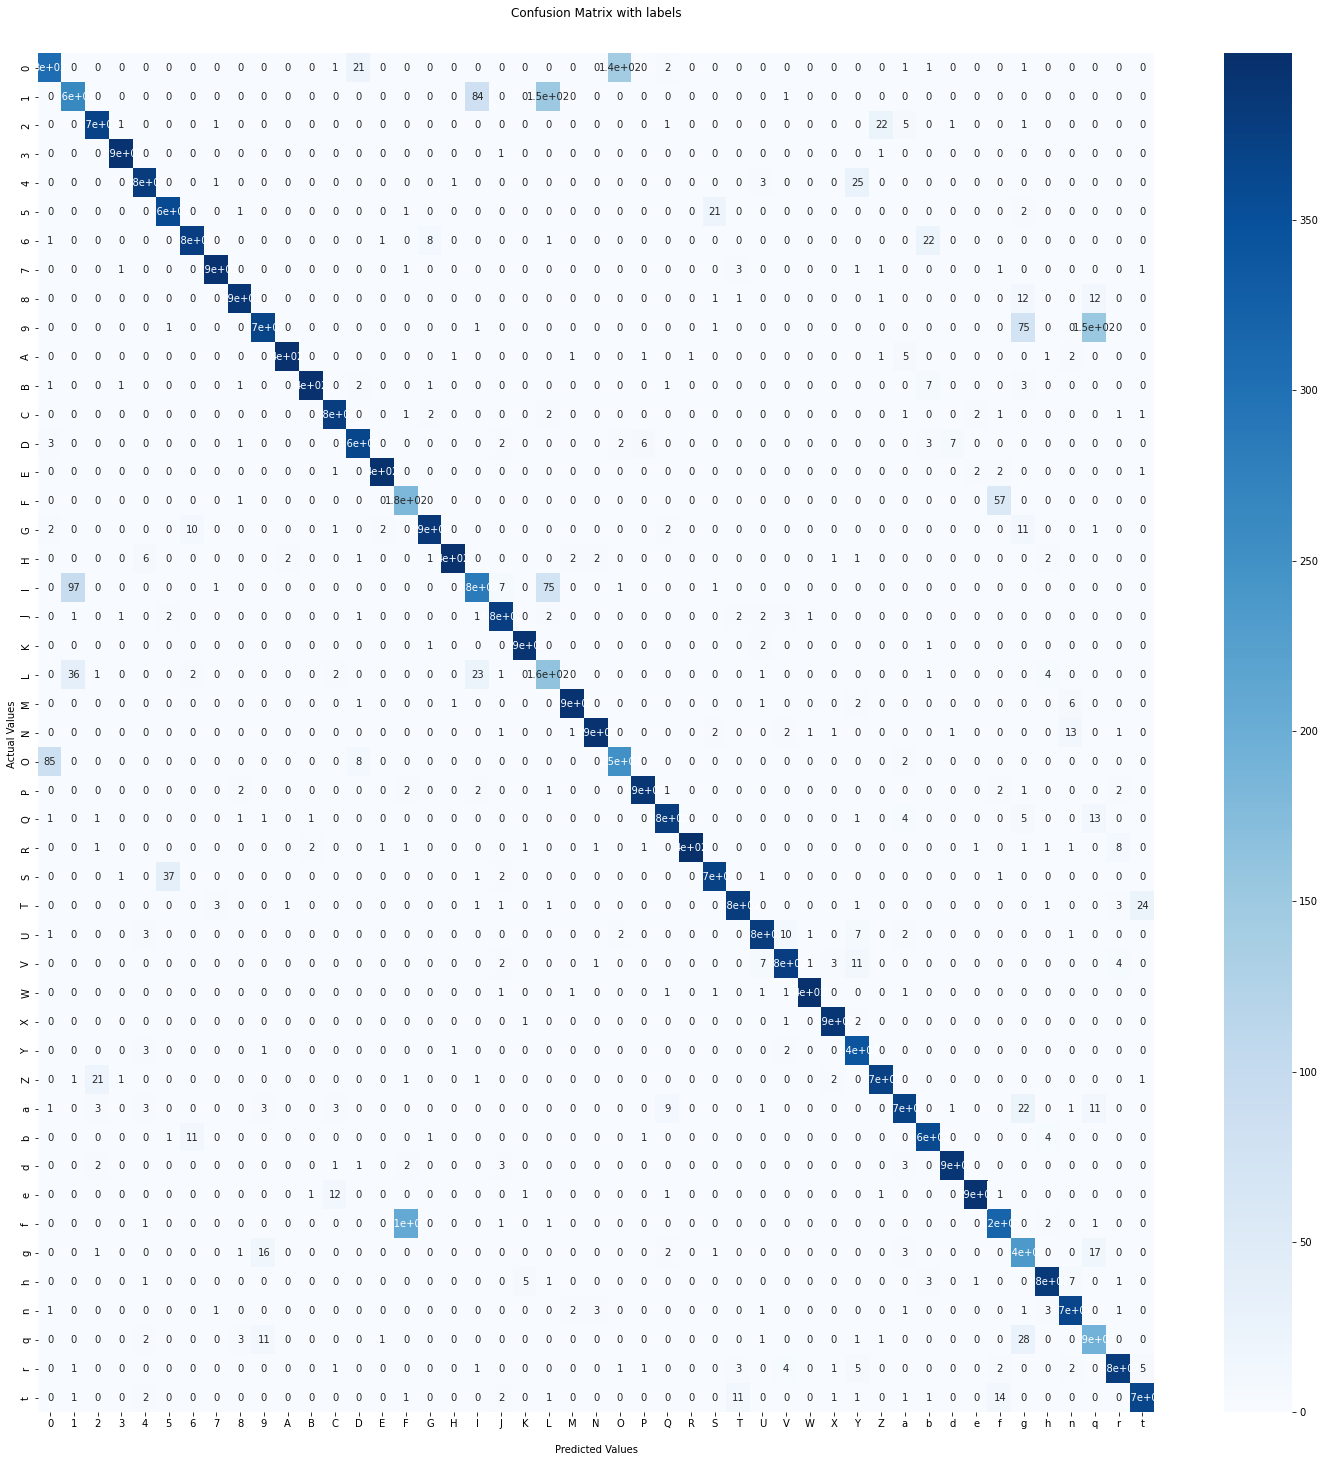

In [61]:
import seaborn as sns
plt.figure(figsize=(25,25))
ax = sns.heatmap(matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(lables)
ax.yaxis.set_ticklabels(lables)

## Display the visualization of the Confusion Matrix.
plt.show()